<a href="https://colab.research.google.com/github/Udinanon/CV-Project-Prototypes/blob/main/Hand_Segmentation_CNNs.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Old Setup Code
will have to remove/reoder when the new version is done




In [1]:

%ls
%cd drive/MyDrive/
%cd Colab_Notebooks/faces_datasets/
# move to correct folder

drive/  sample_data/
/content/drive/MyDrive
/content/drive/MyDrive/Colab_Notebooks/faces_datasets


In [ ]:
# basic imports
import torchvision
import numpy as np
import torch
from PIL import Image
import os
os.getcwd()


'/content/drive/MyDrive/Colab_Notebooks/faces_datasets'

# loading one image and visualizing the model
very basic

In [ ]:
import torchvision.transforms as transforms
imsize = 256

loader = transforms.Compose([transforms.ToTensor()])

def image_loader(image_name):
    image = Image.open(image_name)
    image = loader(image).float()
    image = torch.tensor(image, requires_grad=True)
    image = image.unsqueeze(0)
    return image

model(image_loader("images/train/CARDS_LIVINGROOM_T_B_frame_0001.jpg"))

In [ ]:
COCO_INSTANCE_CATEGORY_NAMES = [
    '__background__', 'person', 'bicycle', 'car', 'motorcycle', 'airplane', 'bus',
    'train', 'truck', 'boat', 'traffic light', 'fire hydrant', 'N/A', 'stop sign',
    'parking meter', 'bench', 'bird', 'cat', 'dog', 'horse', 'sheep', 'cow',
    'elephant', 'bear', 'zebra', 'giraffe', 'N/A', 'backpack', 'umbrella', 'N/A', 'N/A',
    'handbag', 'tie', 'suitcase', 'frisbee', 'skis', 'snowboard', 'sports ball',
    'kite', 'baseball bat', 'baseball glove', 'skateboard', 'surfboard', 'tennis racket',
    'bottle', 'N/A', 'wine glass', 'cup', 'fork', 'knife', 'spoon', 'bowl',
    'banana', 'apple', 'sandwich', 'orange', 'broccoli', 'carrot', 'hot dog', 'pizza',
    'donut', 'cake', 'chair', 'couch', 'potted plant', 'bed', 'N/A', 'dining table',
    'N/A', 'N/A', 'toilet', 'N/A', 'tv', 'laptop', 'mouse', 'remote', 'keyboard', 'cell phone',
    'microwave', 'oven', 'toaster', 'sink', 'refrigerator', 'N/A', 'book',
    'clock', 'vase', 'scissors', 'teddy bear', 'hair drier', 'toothbrush'
]

import cv2, random
import matplotlib.pyplot as plt

image_path = "images/train/CARDS_LIVINGROOM_T_B_frame_0001.jpg"

def get_prediction(img_path, threshold):
  img = Image.open(img_path)
  transform = transforms.Compose([transforms.ToTensor()])
  img = transform(img)
  pred = model([img])
  pred_score = list(pred[0]['scores'].detach().numpy())
  pred_t = [pred_score.index(x) for x in pred_score if x>threshold][-1]
  masks = (pred[0]['masks']>0.5).squeeze().detach().cpu().numpy()
  pred_class = [COCO_INSTANCE_CATEGORY_NAMES[i] for i in list(pred[0]['labels'].numpy())]
  pred_boxes = [[(i[0], i[1]), (i[2], i[3])] for i in list(pred[0]['boxes'].detach().numpy())]
  masks = masks[:pred_t+1]
  pred_boxes = pred_boxes[:pred_t+1]
  pred_class = pred_class[:pred_t+1]
  return masks, pred_boxes, pred_class


def random_colour_masks(image):
  colours = [[0, 255, 0],[0, 0, 255],[255, 0, 0],[0, 255, 255],[255, 255, 0],[255, 0, 255],[80, 70, 180],[250, 80, 190],[245, 145, 50],[70, 150, 250],[50, 190, 190]]
  r = np.zeros_like(image).astype(np.uint8)
  g = np.zeros_like(image).astype(np.uint8)
  b = np.zeros_like(image).astype(np.uint8)
  r[image == 1], g[image == 1], b[image == 1] = colours[random.randrange(0,10)]
  coloured_mask = np.stack([r, g, b], axis=2)
  return coloured_mask

def instance_segmentation_api(img_path, threshold=0.5, rect_th=3, text_size=3, text_th=3):
  masks, boxes, pred_cls = get_prediction(img_path, threshold)
  img = cv2.imread(img_path)
  img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
  for i in range(len(masks)):
    rgb_mask = random_colour_masks(masks[i])
    img = cv2.addWeighted(img, 1, rgb_mask, 0.5, 0)
    cv2.rectangle(img, boxes[i][0], boxes[i][1],color=(0, 255, 0), thickness=rect_th)
    cv2.putText(img,pred_cls[i], boxes[i][0], cv2.FONT_HERSHEY_SIMPLEX, text_size, (0,255,0),thickness=text_th)
  plt.figure(figsize=(20,30))
  plt.imshow(img)
  plt.xticks([])
  plt.yticks([])
  plt.show()

instance_segmentation_api(image_path)


### BTW how to read all sys info on the machine

In [ ]:
import tensorflow as tf
from tensorflow.python.client import device_lib

print("CPU")
!cat /proc/cpuinfo
print("RAM")
!cat /proc/meminfo

print("GPU?")
tf.test.gpu_device_name()
device_lib.list_local_devices()

# New Dataset approach

## Dataset setup with better scripts

In [ ]:
# from here https://github.com/guglielmocamporese/hands-segmentation-pytorch/blob/master/scripts/download_datasets.sh

%%shell
# Download datasets
DATA_BASE_PATH="."
mkdir -p "${DATA_BASE_PATH}"

In [ ]:
%%shell
# HandOverFace (HOF)
mkdir -p "./HOF"
gdown "https://drive.google.com/uc?id=1hHUvINGICvOGcaDgA5zMbzAIUv7ewDd3" -O "./HOF/hand_over_face_corrected.tar.gz"
tar -xvf "./HOF/hand_over_face_corrected.tar.gz" -C "./HOF"
rm "./HOF/hand_over_face_corrected.tar.gz"

In [ ]:
%%shell
# EgoHands
wget "http://vision.soic.indiana.edu/egohands_files/egohands_data.zip" -O "${DATA_BASE_PATH}/egohands_data.zip"
unzip "${DATA_BASE_PATH}/egohands_data.zip" -d "${DATA_BASE_PATH}/egohands_data"
rm "${DATA_BASE_PATH}/egohands_data.zip"

## working on egohands dataset

In [ ]:
import scipy.io
from pprint import pprint
from PIL import Image, ImageDraw
## allows us to geenrate masks from the egohands datasets and not just boxes
# all from https://github.com/guglielmocamporese/hands-segmentation-pytorch/blob/d4643f3a2137e90e60b8eba0d5bb06bb25552841/dataloader.py#L356

data_base_path = os.path.join("EGO", "egohands_data")
frame_tmpl='frame_{:04d}.jpg'
metadata = scipy.io.loadmat(os.path.join(data_base_path, 'metadata.mat'))
annotations = metadata['video'][0]
x = list(annotations[0])
video_id, _, _, _, _, _, labeled_frames = x # more info the readme
video_id = video_id[0]
labeled_frames = labeled_frames[0]
frame_ann = labeled_frames[0]
frame_id = frame_ann[0].reshape(-1)[0]
image_paths = []
masks_poly = []
polygons = []
for idx, ll in enumerate(frame_ann):
  if (idx > 0) and len(ll) > 0:
    p = [tuple(pp) for pp in ll]
    polygons += [p]
print(len(polygons))
image_path = os.path.join(data_base_path, '_LABELLED_SAMPLES', video_id, frame_tmpl.format(frame_id))
image = Image.open(image_path)
image


w, h = image.size
mask = Image.new('L', (w, h), 0)
ImageDraw.Draw(mask).polygon(polygons[1], outline=255, fill=255)
mask



## setup code


In [2]:
from torch.utils.data import Dataset
import scipy.io
from pprint import pprint
from PIL import Image, ImageDraw
import torchvision.transforms as transforms
import os
import numpy as np
import csv
import torch
from PIL import Image
import torchvision

## valid egohands dataset with masks

In [3]:
class EgoHandsDataset(Dataset):
    """
        EgoHands dataset from http://vision.soic.indiana.edu/projects/egohands.
        Images and masks of dims [720, 1280].
        modified to support instance segmentation buy generting multiple masks
        one for each hand
    """
    def __init__(self, data_base_path, image_transform=None, 
                 mask_transform=None, seed=1234, frame_tmpl='frame_{:04d}.jpg', 
                 mask_shape=None):
        super(EgoHandsDataset, self).__init__()
        self.data_base_path = data_base_path
        self.image_transform = image_transform
        self.mask_transform = mask_transform
        self.seed = seed
        self.frame_tmpl = frame_tmpl
        self.metadata = scipy.io.loadmat(os.path.join(self.data_base_path, 'metadata.mat'))
        self.mask_shape = mask_shape
        self.image_paths, self.mask_poly = self._get_paths()

    def _compute_masks(self, polygons, height, width):
        masks = []
        for poly in polygons:
              mask = Image.new('L', (width, height), 0)
              ImageDraw.Draw(mask).polygon(poly, outline=1, fill=1)

              mask = np.array(mask)
              masks.append(mask)
        return masks

    def _get_paths(self):

        annotations = self.metadata['video'][0] # 48 annotations (of the 48 videos)
        image_paths = []
        masks_poly = []
        for x in annotations:
            x = list(x)
            video_id, _, _, _, _, _, labeled_frames = x # more info the readme
            video_id = video_id[0]
            labeled_frames = labeled_frames[0]

            # Get frame annotation
            for frame_ann in labeled_frames:
                frame_id = frame_ann[0].reshape(-1)[0]
                polygons = []
                for idx, ll in enumerate(frame_ann):
                    if (idx > 0) and len(ll) > 0:
                        p = [tuple(pp) for pp in ll]
                        polygons += [p]
                masks_poly += [polygons]

                image_path = os.path.join(self.data_base_path, '_LABELLED_SAMPLES', video_id, self.frame_tmpl.format(frame_id))
                image_paths += [image_path]

        # Split data
        num_samples = len(image_paths)
        idxs = np.arange(num_samples)
        np.random.seed(self.seed)
        np.random.shuffle(idxs)
        return image_paths, masks_poly

    def __len__(self):
        return len(self.image_paths)

    def __getitem__(self, idx):

        # Load image and mask
        image = Image.open(self.image_paths[idx]).convert("RGB")
        if self.mask_shape is None:
            w, h = image.size
        else:
            h, w = self.mask_shape
        masks = self._compute_masks(self.mask_poly[idx], h, w)
        target = {}
        num_objs = len(masks)
        boxes = []
        for i in range(num_objs):
            
            pos = np.where(masks[i])
            xmin = np.min(pos[1])
            xmax = np.max(pos[1])
            ymin = np.min(pos[0])
            ymax = np.max(pos[0])

            boxes.append([xmin, ymin, xmax, ymax])

        boxes = torch.as_tensor(boxes, dtype=torch.float32)
        # there is only one class
        labels = torch.ones((num_objs,), dtype=torch.int64)

        image_id = torch.tensor([idx])
        if num_objs > 0:
            area = (boxes[:, 3] - boxes[:, 1]) * (boxes[:, 2] - boxes[:, 0])
        else:
            area = (torch.as_tensor(0))
        # suppose all instances are not crowd
        iscrowd = torch.zeros((num_objs,), dtype=torch.int64)

        target = {}
        target["boxes"] = boxes
        target["labels"] = labels
        masks = torch.as_tensor(masks, dtype=torch.uint8)
        target["masks"] = masks
        target["image_id"] = image_id
        target["area"] = area
        target["iscrowd"] = iscrowd

        # Transforms
        if self.image_transform is not None:
            image = self.image_transform(image)
        else:
          tensor_trans = transforms.Compose([transforms.ToTensor()])
          image = tensor_trans(image)
        return image, target

In [ ]:
egohands = EgoHandsDataset("./egohands_data/")
egohands[0]

### tester for it 

In [8]:

#model = torchvision.models.detection.maskrcnn_resnet50_fpn(pretrained=True)
model = get_model_instance_segmentation(2)

egohands = EgoHandsDataset("./egohands_data/")
egohands[0]
data_loader = torch.utils.data.DataLoader(
    egohands, batch_size=2, shuffle=True, num_workers=4,
    collate_fn=collate_fn
)
# For Training
images,targets = next(iter(data_loader))
print(len(images))
images = list(image for image in images)
targets = [{k: v for k, v in t.items()} for t in targets]
output = model(images,targets)   # Returns losses and detections
#print("IN IMGS", images)
#print("IN TARGETS", targets)
print("TRAIN OUTPUT", output)
# For inference
model.eval()
images,targets = next(iter(data_loader))
print(len(images))
images = list(image for image in images)

predictions = model(images)
#print("IN IMGS 2", images)

print(len(predictions[1]["masks"])) 
#print("OUT PREDICT", predictions)

/usr/local/lib/python3.7/dist-packages/torchvision/models/_utils.py:209: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and will be removed in 0.15, please use 'weights' instead.
  f"The parameter '{pretrained_param}' is deprecated since 0.13 and will be removed in 0.15, "
/usr/local/lib/python3.7/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and will be removed in 0.15. The current behavior is equivalent to passing `weights=MaskRCNN_ResNet50_FPN_Weights.COCO_V1`. You can also use `weights=MaskRCNN_ResNet50_FPN_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/maskrcnn_resnet50_fpn_coco-bf2d0c1e.pth" to /root/.cache/torch/hub/checkpoints/maskrcnn_resnet50_fpn_coco-bf2d0c1e.pth


  0%|          | 0.00/170M [00:00<?, ?B/s]

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:102: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at  ../torch/csrc/utils/tensor_new.cpp:201.)
/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:560: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


2
TRAIN OUTPUT {'loss_classifier': tensor(0.9919, grad_fn=<NllLossBackward0>), 'loss_box_reg': tensor(0.4107, grad_fn=<DivBackward0>), 'loss_mask': tensor(4.3744, grad_fn=<BinaryCrossEntropyWithLogitsBackward0>), 'loss_objectness': tensor(0.0504, grad_fn=<BinaryCrossEntropyWithLogitsBackward0>), 'loss_rpn_box_reg': tensor(0.0143, grad_fn=<DivBackward0>)}
2
100


100
3
(1280, 720)
(1280, 720)


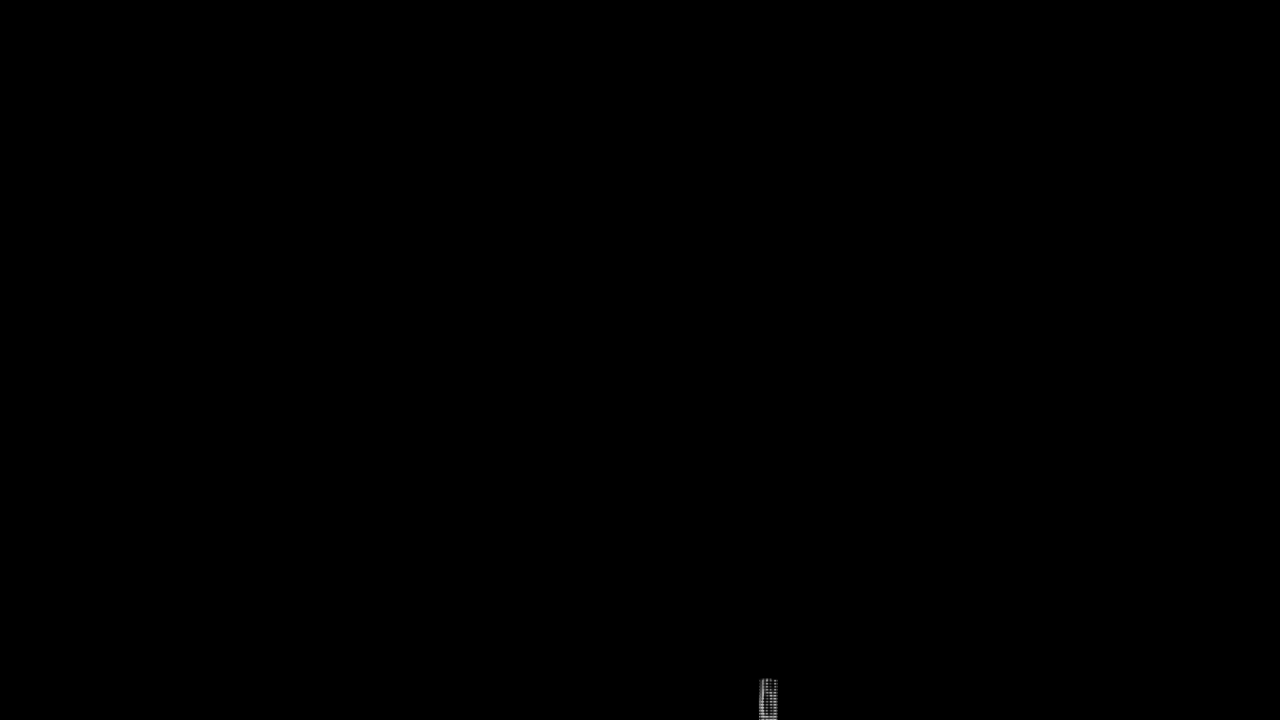

In [34]:
print(len(predictions[1]["masks"])) 
print(len(targets[1]["masks"]))
raster = transforms.ToPILImage()
print(raster(images[1]).size)
print(raster(predictions[1]["masks"][7]).size)
display(raster(predictions[1]["masks"][7]))
#display(raster(images[1]))

## working on HOF dataset


In [ ]:
## loosely based on https://github.com/kekeller/LabelMeMaskParser


import xml.etree.ElementTree as et

def parsePolygon( etelem ):
    points = []
    for pt in etelem.findall('pt'):
        num = pt.find('x').text
        if '.' in num: 
            tx = int(float(num))
        else:
            tx = int(num)
        num = pt.find('y').text
        if '.' in num:  
            ty = int(float(num))
        else:
            ty = int(num)

        points.append(tx)
        points.append(ty)
    return points


def parse_xml(file):
    tree = et.parse(file)
    root = tree.getroot()
    file_name = root.findall('filename')[0].text
    polygon = []
    name_list = []
    image_size = [int(root.findall('./imagesize/ncols')[0].text), int(root.findall('./imagesize/nrows')[0].text)]

    for lmobj in root.findall('object'):
        deleted = lmobj.find('deleted').text
        if deleted=='1':
            continue
        polygon.append(parsePolygon(lmobj.find('polygon')))
        
    masks = []
    for poly in polygon:
        img = Image.new("RGB", image_size, (0, 0, 0) )
        color = (255,255,255)
        if (len(poly) < 3): continue
        ImageDraw.Draw(img).polygon(poly, outline=color, fill=color)
        mask = np.array(img)
        masks.append(mask)
    return masks


In [ ]:

class HOFDataset(Dataset):
    """
        HandOverFace dataset from https://drive.google.com/file/d/1hHUvINGICvOGcaDgA5zMbzAIUv7ewDd3/view?usp=drive_open.
        Images and masks of dims [384, 216]
        modified to support instance segmentation
        https://github.com/aurooj/Hand-Segmentation-in-the-Wild
    """
    def __init__(self, data_base_path, image_transform=None, 
                 mask_transform=None, seed=1234):
        super(HOFDataset, self).__init__()
        self.data_base_path = data_base_path
        self.image_transform = image_transform
        self.mask_transform = mask_transform
        self.seed = seed
        self.image_paths, self.mask_paths = self._get_paths()

    def _get_paths(self):

        # Image paths
        image_names = sorted(os.listdir(os.path.join(self.data_base_path, 'images_resized')))
        image_paths = [os.path.join(self.data_base_path, 'images_resized', f) for f in image_names]

        # Mask paths
        mask_paths = [f.replace('images_resized', 'annotations').replace('.jpg', '.xml') for f in image_paths]

        # Split data
        num_samples = len(image_paths)
        idxs = np.arange(num_samples)
        np.random.seed(self.seed)
        np.random.shuffle(idxs)
        return image_paths, mask_paths

    def __len__(self):
        return len(self.image_paths)

    def __getitem__(self, idx):

        # Load image and mask
        image = Image.open(self.image_paths[idx])
        mask_path = self.mask_paths[idx]
        masks = parse_xml(mask_path)

        #create target for returning
        target = {}
        num_objs = len(masks)
        boxes = []
        for i in range(num_objs):
            #generate the bounding box
            pos = np.where(masks[i])
            xmin = np.min(pos[1])
            xmax = np.max(pos[1])
            ymin = np.min(pos[0])
            ymax = np.max(pos[0])
            boxes.append([xmin, ymin, xmax, ymax])

        boxes = torch.as_tensor(boxes, dtype=torch.float32)
        # there is only one class
        labels = torch.ones((num_objs,), dtype=torch.int64)

        image_id = torch.tensor([idx])
        area = (boxes[:, 3] - boxes[:, 1]) * (boxes[:, 2] - boxes[:, 0])
        # suppose all instances are not crowd
        iscrowd = torch.zeros((num_objs,), dtype=torch.int64)

        target = {}
        target["boxes"] = boxes
        target["labels"] = labels
        masks = torch.as_tensor(masks, dtype=torch.uint8)
        target["masks"] = masks
        target["image_id"] = image_id
        target["area"] = area
        target["iscrowd"] = iscrowd
        # Transforms
        if self.image_transform is not None:
            image = self.image_transform(image)

        return image, target

<Element 'annotation' at 0x7f9176e77230>
0


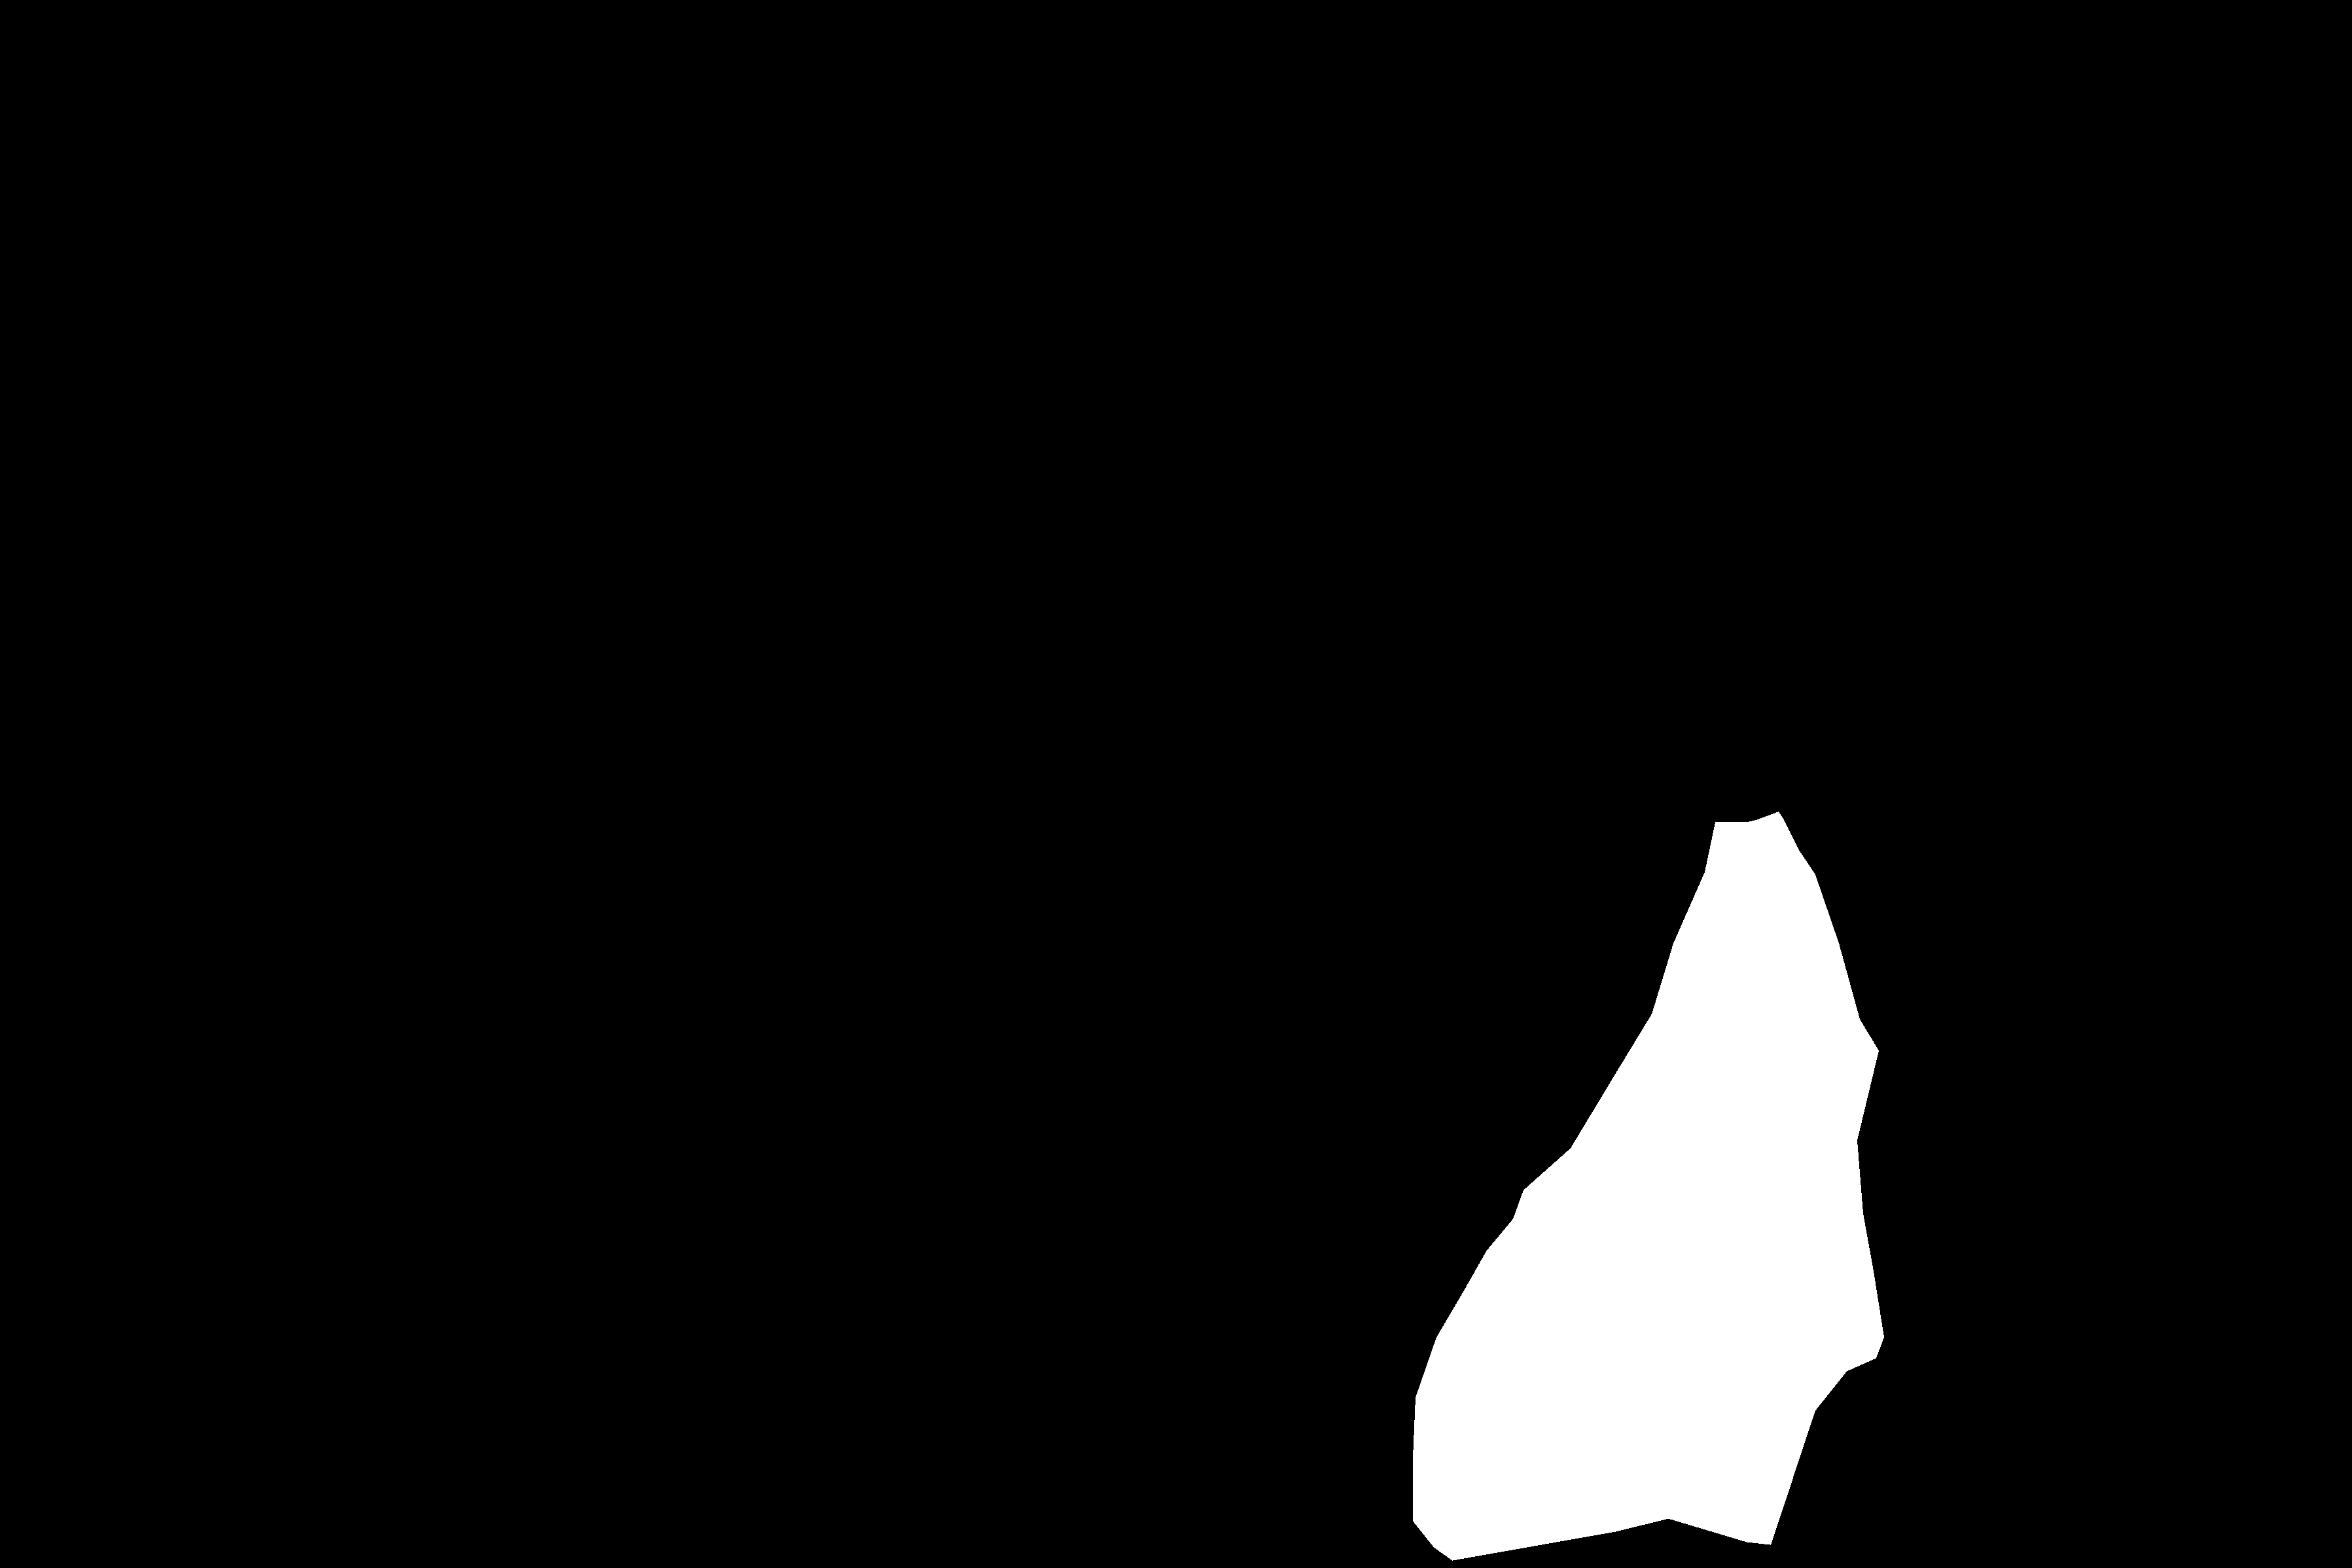

(<PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=384x216 at 0x7F9149358F10>,
 {'area': tensor([822536.]),
  'boxes': tensor([[2159., 1240., 2878., 2384.]]),
  'image_id': tensor([0]),
  'iscrowd': tensor([0]),
  'labels': tensor([1]),
  'masks': tensor([[[[0, 0, 0],
            [0, 0, 0],
            [0, 0, 0],
            ...,
            [0, 0, 0],
            [0, 0, 0],
            [0, 0, 0]],
  
           [[0, 0, 0],
            [0, 0, 0],
            [0, 0, 0],
            ...,
            [0, 0, 0],
            [0, 0, 0],
            [0, 0, 0]],
  
           [[0, 0, 0],
            [0, 0, 0],
            [0, 0, 0],
            ...,
            [0, 0, 0],
            [0, 0, 0],
            [0, 0, 0]],
  
           ...,
  
           [[0, 0, 0],
            [0, 0, 0],
            [0, 0, 0],
            ...,
            [0, 0, 0],
            [0, 0, 0],
            [0, 0, 0]],
  
           [[0, 0, 0],
            [0, 0, 0],
            [0, 0, 0],
            ...,
        

In [ ]:
hofdataset = HOFDataset("./hand_over_face/")
hofdataset[0]

# Finetuning the model
now we get to the good stuff


In [5]:
import torchvision
from torchvision.models.detection.faster_rcnn import FastRCNNPredictor
from torchvision.models.detection.mask_rcnn import MaskRCNNPredictor


def get_model_instance_segmentation(num_classes):
    # load an instance segmentation model pre-trained on COCO
    model = torchvision.models.detection.maskrcnn_resnet50_fpn(pretrained=True)

    # get number of input features for the classifier
    in_features = model.roi_heads.box_predictor.cls_score.in_features
    # replace the pre-trained head with a new one
    model.roi_heads.box_predictor = FastRCNNPredictor(in_features, num_classes)

    # now get the number of input features for the mask classifier
    in_features_mask = model.roi_heads.mask_predictor.conv5_mask.in_channels
    hidden_layer = 256
    # and replace the mask predictor with a new one
    model.roi_heads.mask_predictor = MaskRCNNPredictor(in_features_mask,
                                                       hidden_layer,
                                                       num_classes)

    return model
    

In [7]:


def get_transform(train= False):
    transform_list = []
    transform_list.append(transforms.ToTensor())
    if train:
        pass
        #transforms.append(T.RandomHorizontalFlip(0.5))
    return transforms.Compose(transform_list)


def collate_fn(batch):
    return tuple(zip(*batch))


In [9]:
from engine import train_one_epoch, evaluate


def main():
    # train on the GPU or on the CPU, if a GPU is not available
    device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
    print(device)
    # our dataset has two classes only - background and person
    num_classes = 2
    # use our dataset and defined transformations

    dataset = EgoHandsDataset("./egohands_data/")
    dataset_test = EgoHandsDataset("./egohands_data/")

    # split the dataset in train and test set
    indices = torch.randperm(len(dataset)).tolist()
    dataset = torch.utils.data.Subset(dataset, indices[:-50])
    dataset_test = torch.utils.data.Subset(dataset_test, indices[-50:])

    # define training and validation data loaders
    data_loader = torch.utils.data.DataLoader(
        dataset, batch_size=2, shuffle=True, num_workers=2,
        collate_fn=collate_fn)

    data_loader_test = torch.utils.data.DataLoader(
        dataset_test, batch_size=1, shuffle=False, num_workers=2,
        collate_fn=collate_fn)

    # get the model using our helper function
    model = get_model_instance_segmentation(num_classes)
    
    # move model to the right device
    model.to(device)
    
    # construct an optimizer
    params = [p for p in model.parameters() if p.requires_grad]
    optimizer = torch.optim.SGD(params, lr=0.005, momentum=0.9, weight_decay=0.0005)
    #optimizer = torch.optim.AdamW(params, lr=0.0001, weight_decay=0.0007)
    # and a learning rate scheduler
    lr_scheduler = torch.optim.lr_scheduler.StepLR(optimizer,
                                                   step_size=2,
                                                   gamma=0.1)

    # let's train it for 10 epochs
    num_epochs = 10

    for epoch in range(num_epochs):
        # train for one epoch, printing every 10 iterations
        train_one_epoch(model, optimizer, data_loader, device, epoch, print_freq=10)

        # update the learning rate
        lr_scheduler.step()
        # evaluate on the test dataset
        #evaluate(model, data_loader_test, device=device)

    print("That's it!")
main()

cuda


/usr/local/lib/python3.7/dist-packages/torchvision/models/_utils.py:209: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and will be removed in 0.15, please use 'weights' instead.
  f"The parameter '{pretrained_param}' is deprecated since 0.13 and will be removed in 0.15, "
/usr/local/lib/python3.7/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and will be removed in 0.15. The current behavior is equivalent to passing `weights=MaskRCNN_ResNet50_FPN_Weights.COCO_V1`. You can also use `weights=MaskRCNN_ResNet50_FPN_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Epoch: [0]  [   0/2375]  eta: 6:36:26  lr: 0.000010  loss: 3.1623 (3.1623)  loss_classifier: 0.5205 (0.5205)  loss_box_reg: 0.2036 (0.2036)  loss_mask: 2.3362 (2.3362)  loss_objectness: 0.0847 (0.0847)  loss_rpn_box_reg: 0.0173 (0.0173)  time: 10.0152  data: 1.3558  max mem: 2508
Epoch: [0]  [  10/2375]  eta: 1:01:27  lr: 0.000060  loss: 2.9404 (2.8851)  loss_classifier: 0.5205 (0.5061)  loss_box_reg: 0.2863 (0.2704)  loss_mask: 1.9739 (1.9726)  loss_objectness: 0.0847 (0.1092)  loss_rpn_box_reg: 0.0173 (0.0267)  time: 1.5592  data: 0.2498  max mem: 2781
Epoch: [0]  [  20/2375]  eta: 0:44:46  lr: 0.000110  loss: 1.9465 (2.3159)  loss_classifier: 0.4105 (0.4274)  loss_box_reg: 0.2863 (0.2702)  loss_mask: 1.1219 (1.4771)  loss_objectness: 0.0724 (0.1182)  loss_rpn_box_reg: 0.0132 (0.0229)  time: 0.6969  data: 0.1231  max mem: 2783
Epoch: [0]  [  30/2375]  eta: 0:40:02  lr: 0.000160  loss: 1.4477 (1.9390)  loss_classifier: 0.3124 (0.3767)  loss_box_reg: 0.3205 (0.2974)  loss_mask: 0.6651 

AssertionError: ignored

In [ ]:
!nvidia-smi
!nvcc --version

In [ ]:
model = get_model_instance_segmentation(2)
model

MaskRCNN(
  (transform): GeneralizedRCNNTransform(
      Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
      Resize(min_size=(800,), max_size=1333, mode='bilinear')
  )
  (backbone): BackboneWithFPN(
    (body): IntermediateLayerGetter(
      (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
      (bn1): FrozenBatchNorm2d(64, eps=0.0)
      (relu): ReLU(inplace=True)
      (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
      (layer1): Sequential(
        (0): Bottleneck(
          (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn1): FrozenBatchNorm2d(64, eps=0.0)
          (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
          (bn2): FrozenBatchNorm2d(64, eps=0.0)
          (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn3): FrozenBatchNorm2d(256, eps=0.0)
          (relu): ReLU(in